# 04 — RNN/LSTM Training with MLflow (Reliance Industries)

Train sequence models (LSTM) on time-windowed features for Reliance stock.
Log all runs, hyperparameters, metrics, and models to MLflow.

## Why log returns and technical indicators?

- **Log returns**: Additive over time, scale-invariant, more symmetric distribution.
- **RSI**: Momentum indicator (overbought/oversold).
- **MACD**: Trend-following indicator.
- **EMAs**: Short/medium-term trend.
- **Bollinger Bands**: Volatility bands.
- **Calendar features**: Day-of-week, day-of-month, month-end effects.

In [17]:
import os
import json
import yaml
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import mlflow
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator, MACD
from ta.volatility import BollingerBands

# Set working directory to project root if in notebooks/
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

SYMBOL = "RELIANCE"
DATA_FILENAME = "RELI Historical Data.csv"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Working directory: {os.getcwd()}")

Using device: cpu
Working directory: /Users/bhavishya/VSC Projects/stock-price-prediction


In [18]:
# ============== HELPER FUNCTIONS ==============

def parse_volume(vol_str):
    if pd.isna(vol_str) or vol_str == '-':
        return 0.0
    vol_str = str(vol_str).strip()
    if vol_str.endswith('M'):
        return float(vol_str[:-1].replace(',', '')) * 1_000_000
    elif vol_str.endswith('K'):
        return float(vol_str[:-1].replace(',', '')) * 1_000
    elif vol_str.endswith('B'):
        return float(vol_str[:-1].replace(',', '')) * 1_000_000_000
    else:
        try:
            return float(vol_str.replace(',', ''))
        except:
            return 0.0

def parse_price(price_str):
    if pd.isna(price_str) or price_str == '-':
        return np.nan
    return float(str(price_str).replace(',', ''))

def load_reliance_ohlcv():
    """Load Reliance CSV and return OHLCV DataFrame."""
    csv_path = Path(DATA_FILENAME)
    if not csv_path.exists():
        csv_path = Path('notebooks') / DATA_FILENAME
    
    print(f"Loading data from: {csv_path}")
    raw_df = pd.read_csv(csv_path)
    raw_df.columns = [col.strip() for col in raw_df.columns]
    
    for col in ['Price', 'Open', 'High', 'Low']:
        raw_df[col] = raw_df[col].apply(parse_price)
    raw_df['Vol.'] = raw_df['Vol.'].apply(parse_volume)
    
    raw_df = raw_df.rename(columns={
        'Date': 'date', 'Price': 'close', 'Open': 'open',
        'High': 'high', 'Low': 'low', 'Vol.': 'volume',
    })
    raw_df['date'] = pd.to_datetime(raw_df['date'], format='%d-%m-%Y')
    raw_df = raw_df.sort_values('date').set_index('date')
    
    return raw_df[['open', 'high', 'low', 'close', 'volume']].copy()

def add_technical_indicators(df):
    out = df.copy()
    out['rsi'] = RSIIndicator(close=out['close'].squeeze(), window=14).rsi()
    macd = MACD(close=out['close'].squeeze())
    out['macd'] = macd.macd()
    out['ema_10'] = EMAIndicator(close=out['close'].squeeze(), window=10).ema_indicator()
    out['ema_20'] = EMAIndicator(close=out['close'].squeeze(), window=20).ema_indicator()
    bb = BollingerBands(close=out['close'].squeeze(), window=20, window_dev=2)
    out['bb_high'] = bb.bollinger_hband()
    out['bb_low'] = bb.bollinger_lband()
    return out

def add_calendar(df):
    out = df.copy()
    out['dow'] = out.index.dayofweek
    out['dom'] = out.index.day
    out['is_month_end'] = out.index.is_month_end.astype(int)
    return out

def build_target(df):
    out = df.copy()
    price = out['close']
    out['y'] = (np.log(price) - np.log(price.shift(1))).shift(-1)
    return out

def time_split(df, train_end, val_end):
    train_end_dt = pd.to_datetime(train_end)
    val_end_dt = pd.to_datetime(val_end)
    train = df[df.index <= train_end_dt]
    val = df[(df.index > train_end_dt) & (df.index <= val_end_dt)]
    test = df[df.index > val_end_dt]
    return train, val, test

def directional_accuracy(y_true, y_pred):
    return (np.sign(y_true) == np.sign(y_pred)).mean()

def to_supervised(df, feature_cols, target_col, lookback):
    """Convert tabular data to supervised sequences."""
    X, y, idx = [], [], []
    values = df[feature_cols + [target_col]].values
    for i in range(lookback, len(values)):
        X.append(values[i - lookback:i, :-1])
        y.append(values[i, -1])
        idx.append(df.index[i])
    return np.array(X), np.array(y), pd.Index(idx)

def fit_apply_scaler(train_df, val_df, test_df, cols):
    """Fit scaler on train, apply to all splits."""
    scaler = StandardScaler()
    scaler.fit(train_df[cols])
    train_df[cols] = scaler.transform(train_df[cols])
    val_df[cols] = scaler.transform(val_df[cols])
    test_df[cols] = scaler.transform(test_df[cols])
    return scaler, train_df, val_df, test_df

In [19]:
# ============== LSTM MODEL ==============

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)

In [20]:
# ============== LOAD AND PREPARE DATA ==============

df = load_reliance_ohlcv()
df = add_technical_indicators(df)
df = add_calendar(df)
df = build_target(df)
df = df.dropna()

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Columns: {list(df.columns)}")

Loading data from: RELI Historical Data.csv
Dataset shape: (224, 15)
Date range: 2025-01-03 00:00:00 to 2025-11-27 00:00:00
Columns: ['open', 'high', 'low', 'close', 'volume', 'rsi', 'macd', 'ema_10', 'ema_20', 'bb_high', 'bb_low', 'dow', 'dom', 'is_month_end', 'y']


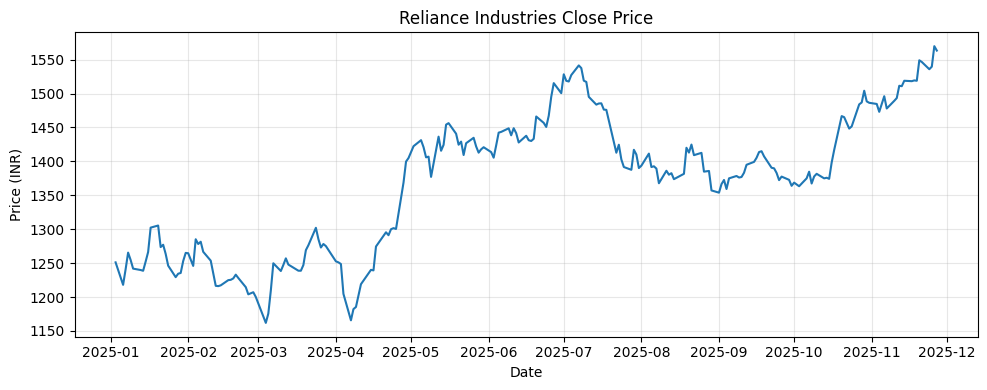

In [21]:
# Visualize price
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['close'])
plt.title('Reliance Industries Close Price')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# ============== TRAINING CONFIGURATION ==============

# 70/15/15 split
n = len(df)
train_idx = int(n * 0.7)
val_idx = int(n * 0.85)
train_end = df.index[train_idx].strftime('%Y-%m-%d')
val_end = df.index[val_idx].strftime('%Y-%m-%d')

# Hyperparameters
lookback = 60
hidden_size = 64
num_layers = 1
batch_size = 64
max_epochs = 30
patience = 5
lr = 1e-3

print(f"Train end: {train_end}")
print(f"Val end: {val_end}")
print(f"Lookback: {lookback}")

Train end: 2025-08-20
Val end: 2025-10-09
Lookback: 60


In [23]:
# ============== PREPARE SEQUENCES ==============

train_df, val_df, test_df = time_split(df, train_end, val_end)
feature_cols = [c for c in df.columns if c != 'y']

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print(f"Features: {len(feature_cols)}")

# Scale features
scaler, train_scaled, val_scaled, test_scaled = fit_apply_scaler(
    train_df.copy(), val_df.copy(), test_df.copy(), feature_cols
)

# Build sequences
Xtr, ytr, _ = to_supervised(train_scaled, feature_cols, 'y', lookback)
Xv, yv, _ = to_supervised(pd.concat([train_scaled.tail(lookback), val_scaled]), feature_cols, 'y', lookback)
Xt, yt, _ = to_supervised(pd.concat([train_scaled.tail(lookback), val_scaled.tail(lookback), test_scaled]), feature_cols, 'y', lookback)

print(f"Train sequences: {Xtr.shape}")
print(f"Val sequences: {Xv.shape}")
print(f"Test sequences: {Xt.shape}")

Train: 157, Val: 34, Test: 33
Features: 14
Train sequences: (97, 60, 14)
Val sequences: (34, 60, 14)
Test sequences: (67, 60, 14)


In [24]:
# ============== SETUP MLFLOW ==============

mlflow.set_tracking_uri('mlruns')
mlflow.set_experiment('reliance_pred')
mlflow.autolog(disable=True)

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")

2025/11/29 01:13:35 INFO mlflow.tracking.fluent: Experiment with name 'reliance_pred' does not exist. Creating a new experiment.


MLflow tracking URI: mlruns


In [25]:
# ============== TRAIN MODEL ==============

# Convert to tensors
Xtr_t = torch.from_numpy(Xtr).float().to(device)
ytr_t = torch.from_numpy(ytr).float().to(device)
Xv_t = torch.from_numpy(Xv).float().to(device)
yv_t = torch.from_numpy(yv).float().to(device)
Xt_t = torch.from_numpy(Xt).float().to(device)
yt_t = torch.from_numpy(yt).float().to(device)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=batch_size, shuffle=True)

# Create model
model = LSTMRegressor(input_size=Xtr.shape[2], hidden_size=hidden_size, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

best_val_loss = float('inf')
epochs_no_improve = 0
best_state_dict = None
train_losses, val_losses = [], []

print(f"Training {SYMBOL} LSTM...")

with mlflow.start_run(run_name=f"{SYMBOL}_lstm"):
    mlflow.log_params({
        'symbol': SYMBOL, 'lookback': lookback, 'hidden_size': hidden_size,
        'num_layers': num_layers, 'batch_size': batch_size, 'epochs': max_epochs, 'patience': patience,
    })
    
    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        
        model.eval()
        with torch.no_grad():
            val_preds = model(Xv_t)
            val_loss = criterion(val_preds, yv_t).item()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{max_epochs} - train_loss={train_loss:.6f} val_loss={val_loss:.6f}")
        
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_state_dict = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve > patience:
                print("Early stopping triggered.")
                break
    
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        val_preds = model(Xv_t).cpu().numpy().ravel()
        test_preds = model(Xt_t).cpu().numpy().ravel()
    
    val_mae = mean_absolute_error(yv, val_preds)
    test_mae = mean_absolute_error(yt, test_preds)
    val_dir_acc = directional_accuracy(yv, val_preds)
    test_dir_acc = directional_accuracy(yt, test_preds)
    
    mlflow.log_metrics({
        'val_mae': val_mae, 'test_mae': test_mae,
        'val_dir_acc': val_dir_acc, 'test_dir_acc': test_dir_acc,
    })
    
    # Save model artifact
    with tempfile.TemporaryDirectory() as tmp:
        model_path = os.path.join(tmp, 'model.pt')
        torch.save(model.state_dict(), model_path)
        mlflow.log_artifacts(tmp, 'torch_model')
    
    print(f"\nTraining completed!")
    print(f"Val MAE: {val_mae:.6f}, Test MAE: {test_mae:.6f}")
    print(f"Val Dir Acc: {val_dir_acc:.4f}, Test Dir Acc: {test_dir_acc:.4f}")

Training RELIANCE LSTM...
Epoch 1/30 - train_loss=0.013614 val_loss=0.004045
Epoch 2/30 - train_loss=0.002752 val_loss=0.001152
Epoch 3/30 - train_loss=0.003256 val_loss=0.000607
Epoch 4/30 - train_loss=0.004235 val_loss=0.000668
Epoch 5/30 - train_loss=0.002633 val_loss=0.001048
Epoch 6/30 - train_loss=0.001062 val_loss=0.001643
Epoch 7/30 - train_loss=0.000673 val_loss=0.002065
Epoch 8/30 - train_loss=0.001118 val_loss=0.002046
Epoch 9/30 - train_loss=0.001408 val_loss=0.001636
Early stopping triggered.

Training completed!
Val MAE: 0.039575, Test MAE: 0.041246
Val Dir Acc: 0.4118, Test Dir Acc: 0.4328


In [26]:
# ============== SAVE MODEL FOR APP ==============

models_dir = Path('models')
models_dir.mkdir(exist_ok=True)

state_path = models_dir / 'reliance_lstm_state.pt'
meta_path = models_dir / 'reliance_lstm_meta.json'

torch.save(model.state_dict(), state_path)

meta = {
    'lookback': lookback,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'feature_cols': feature_cols,
}
with meta_path.open('w') as f:
    json.dump(meta, f, indent=2)

print(f"Saved model to {state_path}")
print(f"Saved metadata to {meta_path}")

Saved model to models/reliance_lstm_state.pt
Saved metadata to models/reliance_lstm_meta.json


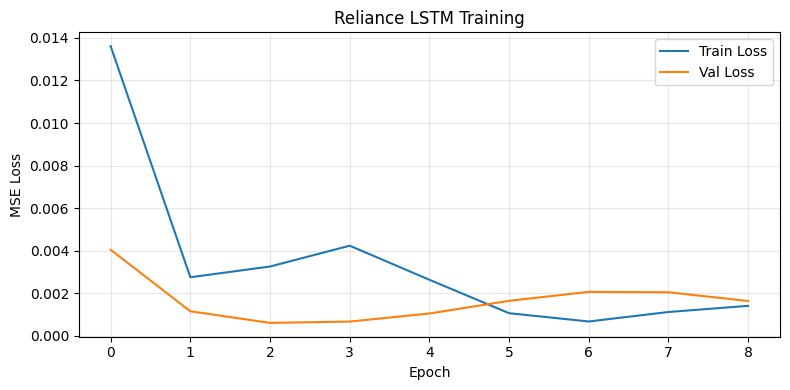

In [27]:
# ============== VISUALIZE TRAINING ==============

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Reliance LSTM Training')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
# ============== SUMMARY ==============

print(f"\n{'='*50}")
print(f"RELIANCE LSTM Model Summary")
print(f"{'='*50}")
print(f"Dataset: {df.shape[0]} samples, {len(feature_cols)} features")
print(f"Lookback: {lookback} days")
print(f"Hidden size: {hidden_size}")
print(f"\nResults:")
print(f"  Val MAE: {val_mae:.6f}")
print(f"  Test MAE: {test_mae:.6f}")
print(f"  Val Dir Acc: {val_dir_acc:.4f}")
print(f"  Test Dir Acc: {test_dir_acc:.4f}")
print(f"\nModel saved to: {state_path}")


RELIANCE LSTM Model Summary
Dataset: 224 samples, 14 features
Lookback: 60 days
Hidden size: 64

Results:
  Val MAE: 0.039575
  Test MAE: 0.041246
  Val Dir Acc: 0.4118
  Test Dir Acc: 0.4328

Model saved to: models/reliance_lstm_state.pt
